# The World's Oldest Companies: Using Pandas to Find Out What, Where, and When
Wikipedia has an interesting entry that lists out [the world's oldest companies](https://en.wikipedia.org/wiki/List_of_oldest_companies). The list includes companies founded before 1700 which are still doing business today. To be part of the list:
> a brand or company name must remain operating, either in whole or in part, since inception.

Sounds like something worth spending an entire afternoon on. So let's see what a little data wrangling with pandas can reveal about this neat dataset.

## Getting and Cleaning the Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Obtaining the Data from the Wikipedia Page
We use pandas' top-level function `pd.read_html` to extract the tables from the page.

In [2]:
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_oldest_companies')

This function grabs all the tables on the page and stores each into its own dataframe. The function then returns a list of these dataframes. Let's see how many tables we got.

In [3]:
len(tables)

6

Great. We got all six tables on the page.

### A First Look
Let's see what the tables look like.

In [4]:
tables[0].head()

,0,1,2,3,4
0,Year,Company,Current location,Field,Sources
1,578,Kongō Gumi,Japan,Construction,[7][8][9]
2,705,Nishiyama Onsen Keiunkan,Japan,Hotel,[10][11]
3,717,Koman,Japan,Hotel,[11][12]
4,718,Hōshi Ryokan,Japan,Hotel,[12][13][14]


In [5]:
tables[3].head()

,0,1,2,3,4
0,Year,Company,Current location,Field,Sources
1,circa 1500,Ammerndorfer,Germany,Mill,[230]
2,1500,Arthur Beale,United Kingdom,Chandler,[231][232]
3,1500,Ubaldo Grazia,Italy,Pottery,[13][28]
4,1501,Fukkodo,Japan,Brushes,[233]


In [6]:
tables[5].head()

,0,1,2,3,4
0,Year,Company,Current location,Field,Sources
1,1650,Aannemers- en Timmerbedrijf Roozemond,Netherlands,Construction,[280]
2,1650,Yukawa,Japan,Sake,[270]
3,1650,Schlossbrauerei Autenrieder,Germany,Brewery,[553]
4,1650,Fachwerk 33,Germany,Restaurant,[554]


### Fixing the Column Names
It seems the column labels we want are not in the header row.

In [7]:
tables[0].columns

Int64Index([0, 1, 2, 3, 4], dtype='int64')

Let's fix that.

In [8]:
# iterate over each table in the list
for table in tables:
    table.columns = table.iloc[0].values    # set first row as col names
    table.drop(0, inplace=True)             # drop the first row
    table.reset_index(drop=True, inplace=True)      # reset the index

In [9]:
tables[0].columns

Index(['Year', 'Company', 'Current location', 'Field', 'Sources'], dtype='object')

In [10]:
tables[0].head()

,Year,Company,Current location,Field,Sources
0,578,Kongō Gumi,Japan,Construction,[7][8][9]
1,705,Nishiyama Onsen Keiunkan,Japan,Hotel,[10][11]
2,717,Koman,Japan,Hotel,[11][12]
3,718,Hōshi Ryokan,Japan,Hotel,[12][13][14]
4,771,Genda Shigyō,Japan,Ceremonial paper goods,[15]


In [11]:
tables[3].columns

Index(['Year', 'Company', 'Current location', 'Field', 'Sources'], dtype='object')

In [12]:
tables[3].head()

,Year,Company,Current location,Field,Sources
0,circa 1500,Ammerndorfer,Germany,Mill,[230]
1,1500,Arthur Beale,United Kingdom,Chandler,[231][232]
2,1500,Ubaldo Grazia,Italy,Pottery,[13][28]
3,1501,Fukkodo,Japan,Brushes,[233]
4,1502,Tsutaya,Japan,Confectionery,[234]


That's much better, although things would have been much, much simpler if we specified the header row when we called `read_html`.

### Combining the Tables
Let's combine the six dataframes into a single dataframe.

In [13]:
data = pd.concat(tables, ignore_index=True)

In [14]:
# check if the merged dataframe has the correct shape
data.shape

(984, 5)

In [15]:
# check if the merged dataframe has the correct columns and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
Year                984 non-null object
Company             984 non-null object
Current location    984 non-null object
Field               984 non-null object
Sources             880 non-null object
dtypes: object(5)
memory usage: 38.5+ KB


Looks good, but needs a bit more cleaning up. Let's start by dropping the `Sources` column since we probably don't need this in our analysis.

In [16]:
data.drop('Sources', axis=1, inplace=True)

In [17]:
# check if the dataframe no longer contains the sources column
data.columns

Index(['Year', 'Company', 'Current location', 'Field'], dtype='object')

### Converting the Year Column into the Right Data Type
We see that the `Year` column is formatted as a string. To make sure this column behaves as expected when we do some operations on it later, let's convert it into the right data type.

In [18]:
data['Year'] = data.Year.str.extract('(\d+)', expand=False).astype('int64')

In [19]:
# check if the dataframe has the right columns and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 4 columns):
Year                984 non-null int64
Company             984 non-null object
Current location    984 non-null object
Field               984 non-null object
dtypes: int64(1), object(3)
memory usage: 30.8+ KB


In our case, the "right" data type turns out to be `int64` since converting into `datetime64` would have created problems for rows with years before 1970, which happens to be all the rows in the dataset. Please tell me  if you know a way to properly convert the `Year` column into the `datetime64` data type.

## Some Basic Data Analysis
Now, we've (hopefully) turned the dataframe into something we can work with. Let the analysis begin!

### Year Founded and Company Age
Let's start by taking some descriptive stats about the company's founding year and its current age. We'll add a new column to show the current age (years since inception).

In [20]:
# I did this in 2018, so let's use that as the current year
data['Age'] = 2018 - data.Year

In [21]:
# check the columns again
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
Year                984 non-null int64
Company             984 non-null object
Current location    984 non-null object
Field               984 non-null object
Age                 984 non-null int64
dtypes: int64(2), object(3)
memory usage: 38.5+ KB


In [22]:
# get some summary statistics
data.describe()

,Year,Age
count,984.000000,984.000000
mean,1560.382114,457.617886
std,160.316378,160.316378
min,578.000000,319.000000
25%,1534.000000,357.000000
50%,1615.000000,403.000000
75%,1661.000000,484.000000
max,1699.000000,1440.000000


We see the following:
* The oldest company (or companies) was (or were) founded in the year 578 and is (are) now 1,440 years old.
* The median age of the world's oldest companies is around 403 years old.

In [23]:
# get the row pertaining to the world's oldest company
data.loc[data.Year.idxmin()]

Year                         578
Company               Kongō Gumi
Current location           Japan
Field               Construction
Age                         1440
Name: 0, dtype: object

The dataset tells us that the world's oldest continuously operating company is [Kongō Gumi](https://en.wikipedia.org/wiki/Kong%C5%8D_Gumi), a Japan-based construction firm. Some quick googling reveals that the company started out building Buddhist temples in the 6th century and was absorbed by Takamatsu Construction in 2006.

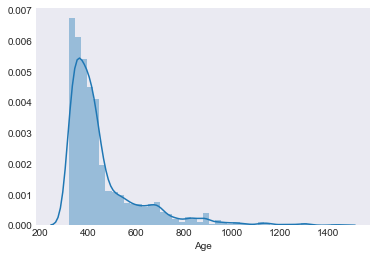

In [24]:
# plot the histogram of the company ages
sns.set_style('dark')
sns.distplot(data.Age)

A histogram of the companies' ages shows a distribution resembling a [Power Law](https://en.wikipedia.org/wiki/Power_law#Power-law_probability_distributions).

### Oldest Companies by Country (or Current Location)
Let's take a look at the dataset at the country level.

In [25]:
# count how many old companies each country in the dataset has
data['Current location'].value_counts()

Japan             520
Germany           180
United Kingdom     45
Austria            43
Switzerland        39
France             28
Italy              25
Netherlands        22
China              12
United States      10
Czech Republic      9
Sweden              8
Poland              8
Belgium             8
Spain               6
Ireland             4
Portugal            3
Norway              2
Finland             2
Slovakia            2
Ukraine             1
Denmark             1
Latvia              1
Canada              1
Netherland          1
Lithuania           1
Turkey              1
Estonia             1
Name: Current location, dtype: int64

More than a majority of the world's oldest companies are currently located in Japan.

But we see one problem with the above result. There are separate entries for "Netherlands" and "Netherland". Let's fix this:

In [26]:
data['Current location'] = data['Current location'].str.replace('Netherland$', 'Netherlands')

In [27]:
# count how many old companies each country in the dataset has
countries_counts = data['Current location'].value_counts()
countries_counts

Japan             520
Germany           180
United Kingdom     45
Austria            43
Switzerland        39
France             28
Italy              25
Netherlands        23
China              12
United States      10
Czech Republic      9
Poland              8
Sweden              8
Belgium             8
Spain               6
Ireland             4
Portugal            3
Slovakia            2
Norway              2
Finland             2
Ukraine             1
Denmark             1
Latvia              1
Lithuania           1
Canada              1
Turkey              1
Estonia             1
Name: Current location, dtype: int64

That's better.

In [28]:
# count how many unique countries in the dataset
data['Current location'].nunique()

27

We see that:
* There are 27 countries included in the dataset
* More than half the world's oldest companies are currently located in Japan.
*

For each country, the oldest companies are:

In [29]:
idx = data.groupby('Current location')['Age'].idxmax()
data.loc[idx].sort_values(by='Year')

,Year,Company,Current location,Field,Age
0,578,Kongō Gumi,Japan,Construction,1440
5,803,Stiftskeller St. Peter,Austria,Restaurant,1215
6,862,Staffelter Hof,Germany,Wine,1156
7,864,Monnaie de Paris,France,Mint,1154
9,886,Royal Mint,United Kingdom,Mint,1132
10,900,Sean's Bar,Ireland,Pub,1118
14,1000,Marinelli Bell Foundry,Italy,Foundry,1018
20,1074,Affligem brewery,Belgium,Brewery,944
31,1135,Munke Mølle,Denmark,Mill,883
50,1230,Gasthof Sternen,Switzerland,Restaurant,788


### Oldest Companies by Industry
Let's now dive into the dataset by industry.

In [30]:
# count how many old companies under each field/industry
data['Field'].value_counts()

Hotel                             117
Brewery                            99
Sake                               85
Restaurant                         80
Confectionery                      71
Wine                               43
Pharmacy                           34
Clothing                           16
Construction                       15
Paper                              13
Foods                              12
Tea                                12
Retailing                          11
Cloth                               9
Foundry                             8
Miso                                7
Pharmaceutical                      7
Chemicals                           7
Soy sauce                           7
Farm                                7
Distillery                          7
Pub                                 7
Bank                                6
Religious goods                     6
Publisher                           6
Mill                                6
Metalwork   

In [31]:
# count how many industries in the dataset
data['Field'].nunique()

211

In [32]:
# get the 20 industries with the greatest number of old companies
data['Field'].value_counts().head(20)

Hotel             117
Brewery            99
Sake               85
Restaurant         80
Confectionery      71
Wine               43
Pharmacy           34
Clothing           16
Construction       15
Paper              13
Foods              12
Tea                12
Retailing          11
Cloth               9
Foundry             8
Miso                7
Pharmaceutical      7
Chemicals           7
Soy sauce           7
Farm                7
Name: Field, dtype: int64

In [33]:
# compute the age stats for each industry
field_stats= data.groupby('Field')['Age'].agg(['mean', 'median', 'max'])

# get the 20 industries with the oldest mean company age
field_by_mean_age = field_stats.sort_values(by='mean', ascending=False).head(20)
field_by_mean_age

,mean,median,max
Field,,,
Ceremonial paper goods,1247.000000,1247.0,1247
Mint,992.000000,1132.0,1154
Woodworking,944.000000,944.0,944
Land & Livestock,890.000000,890.0,890
Harbor,882.000000,882.0,882
Pub,779.142857,776.0,1118
Cognac,748.000000,748.0,748
Inn,705.000000,705.0,705
Mill,677.000000,584.5,950


In [34]:
# get the 20 industries with the oldest company age
field_by_age = field_stats.sort_values(by='max', ascending=False).head(20)
field_by_age

,mean,median,max
Field,,,
Construction,502.133333,404.0,1440
Hotel,517.940171,419.0,1313
Ceremonial paper goods,1247.000000,1247.0,1247
Restaurant,499.237500,463.5,1215
Wine,489.767442,398.0,1156
Mint,992.000000,1132.0,1154
Religious goods,635.833333,464.5,1133
Pub,779.142857,776.0,1118
Foundry,510.875000,387.5,1018


In this part of the analysis, we find that:
* There are 211 industries (or fields) in the dataset.

The oldest companies in 20 chosen industries are:

In [36]:
# get oldest company in each chosen industry (by mean company age)
idx = data.groupby('Field')['Age'].idxmax()
data.loc[idx].loc[data.Field.isin(field_by_mean_age.index.values)]

,Year,Company,Current location,Field,Age
143,1418,Krumbad,Germany,Baths,600
112,1367,H. Rüetschi,Switzerland,Bell,651
104,1350,Schmidberger,Austria,Blacksmith,668
158,1438,Camuffo di Portogruaro,Italy,Boat building,580
4,771,Genda Shigyō,Japan,Ceremonial paper goods,1247
124,1387,Veneranda Fabbrica del Duomo di Milano,Italy,Church,631
60,1270,Frapin,France,Cognac,748
33,1136,Aberdeen Harbour Board,United Kingdom,Harbor,882
39,1184,Kikuoka,Japan,Herbs,834
75,1313,Landgasthof Mayr,Austria,Inn,705


**Conclusion:** We've uncovered some pretty interesting things about the world's oldest companies in this post, but we've managed to only scratch the surface. If you'd like to explore the dataset further, I'm making it available in this file [oldest-companies.csv](https://github.com/ralphqq/oldest-companies-nb/blob/master/oldest-companies.csv).

In [37]:
data.to_csv('oldest-companies.csv', index_label=False)